## Eye event identification

In [1]:
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import pygwalker as pyg
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.GazeCollision import GazeCollision
from src.d03_processing.fixations.VR_IDT import VR_IDT
from src.d03_processing.fixations.I_VDT import I_VDT
from src.d03_processing.fixations.I_HMM import I_HMM
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.feature_extract.to_viewing import to_viewing
from src.d03_processing.fixations.FixAlgos import *
from src.d03_processing.feature_calculate.viewing_compare_calcs import ea_td

In [2]:
# plot functions
def on_off_plot(tps, cols, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    
    # multipliers = list(range(1, len(cols) + 1))
    adders = [float(i) * 1.5 for i in range(len(cols))]
    t = tps.eye_timestamp_ms.to_numpy() 
    print(tps.viewing_id[0])
    t = t - t[0]
    colors = itertools.cycle(["r", "b", "g", "c", "m"])
    
    for i in range(len(cols)):
        y = np.array(tps[cols[i]].to_numpy(), dtype=float)
        y += float(adders[i])
        ax.plot(t, y, color=next(colors))
    
    ax.set_yticks(adders, cols)
    
def get_center(obj, tps, y_adjust=0):
    # display(tps.iloc[:2, :].style)
    row = tps[tps.gaze_object == obj].reset_index(drop=True).iloc[0, :]
    center = (row.object_position_x, row.object_position_z, row.object_position_y + y_adjust) 
    # print(f"{obj}: {row.gaze_object} {center}")
    return center


def viewing_plot(tps, array_objects, gp_lab='table', gp_line=False, ax=None, alpha=0.5):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    camera_pos = np.array([np.nanmean(tps.camera_x), np.nanmean(tps.camera_z), np.nanmean(tps.camera_y)])

    # plot gaze points as points
    x, y, z = tps.gaze_collision_x.to_numpy(),tps.gaze_collision_y.to_numpy(),tps.gaze_collision_z.to_numpy()
    lab = tps.gaze_object == 'Table' if gp_lab=='table' else np.array(tps[gp_lab].to_numpy(), dtype=bool)
    no_lab = np.invert(lab)
    # print(lab)
    # print(no_lab)
    ax.scatter(x[lab], z[lab], y[lab], c='red', s=2, alpha=1)
    ax.scatter(x[no_lab], z[no_lab], y[no_lab], c='g', s=2, alpha=alpha)
    if gp_line:
        ax.plot(x, z, y, c='k', linewidth=0.4, alpha=alpha)

    # draw a cylinder to represent a table
    table_y_scale =  0.06538646
    table_center =  get_center('Table', tps) # center of the cylinder
    camera_vec = table_center - camera_pos
    # print(f"table: {table_center}")
    radius = 0.55  # radius of the cylinder
    height = table_y_scale * 2  # height of the cylinder
    resolution = 20

    # Create the cylinder mesh
    z = np.linspace(table_center[2]-height/2, table_center[2]+height/2, resolution)
    theta = np.linspace(0, 2*np.pi, resolution)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + table_center[0]
    y_grid = radius*np.sin(theta_grid) + table_center[1]

    # Create the Poly3DCollection
    verts = []
    for i in range(len(z)-1):
        verts += [list(zip(x_grid[i], y_grid[i], z_grid[i])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i+1])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i])),
                  list(zip(x_grid[i], y_grid[i], z_grid[i+1]))]
    table = Poly3DCollection(verts, facecolors=[1, 1, 1, 0], edgecolors=[0, 0, 0, 0.2], alpha=0.0)
    table.set_zsort('min')
    ax.add_collection3d(table)

    for obj in array_objects:
        sphere_center = get_center(obj, tps)
        sphere_radius = 0.12 if obj == 'InvisibleObject' else collision_sphere_radius(sphere_center, camera_pos)
        sphere_center = get_center(obj, tps, sphere_radius)
        # print(f"{obj}: {sphere_center}")
        # sphere_center = get_center(obj, tps)
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 30)
        x = sphere_radius * np.outer(np.cos(u), np.sin(v)) + sphere_center[0]
        y = sphere_radius * np.outer(np.sin(u), np.sin(v)) + sphere_center[1]
        z = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v)) + sphere_center[2]
        c = [0, 0.8, 0.8, 0.5] if obj == 'InvisibleObject' else [0, 0, 1, 0.5]
        # print(c)
        sphere = ax.plot_surface(x, y, z, color=c, alpha=0.05)
        sphere.set_edgecolor(c)


    # set axis limits and labels
    ax_len = 0.55
    ax.set_xlim([table_center[0]-ax_len, table_center[0]+ax_len])
    ax.set_ylim([table_center[1]-ax_len, table_center[1]+ax_len])
    ax.set_zlim([table_center[2]-ax_len, table_center[2]+ax_len])
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_axis_off()
    
    azimuthal_angle = 180 + (np.arctan2(camera_vec[1], camera_vec[0]) * 180 / np.pi)
    polar_angle = 180 - (np.arccos(camera_vec[2] / np.linalg.norm(camera_vec)) * 180 / np.pi)

    # Convert angles to radians
    azimuthal_angle_rad = np.deg2rad(azimuthal_angle)
    polar_angle_rad = np.deg2rad(polar_angle)
    # print(f'elev: {polar_angle}, azim: {azimuthal_angle}')
    ax.view_init(elev=polar_angle, azim=azimuthal_angle)



def fixation_plot(tps, fix_df, fix_range='default', ax=None, gp_lab='fixation'):
    full_objects = np.unique(tps.gaze_object)
    # array_objects = TaskObjects.array_and_invisible
    array_objects = ['InvisibleObject', *TaskObjects.array_objects]
    objects = full_objects[np.isin(full_objects,np.array(array_objects))]
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    viewing_plot(tps, objects, gp_lab=gp_lab, gp_line=False, ax=ax, alpha=0.2)
    fixations = fix_df[fix_df.fixation_or_saccade=='fixation'].reset_index(drop=True)
    size_scaler = 1
    arrow_len = 0.75
    start_fix = 0 if fix_range == 'default' else fix_range[0]
    end_fix = len(fixations) if fix_range == 'default' else fix_range[1]
    for i in range(start_fix, end_fix):
        s = size_scaler * fixations.duration_time[i]
        x, y, z = (fixations.centroid_x[i], fixations.centroid_z[i], fixations.centroid_y[i])
        ax.scatter(x, y, z, c='green', s=s, alpha=0.4)
        ax.text(x, y, z, i, color='green')
        if i > 0:
            prev_x, prev_y, prev_z = (fixations.centroid_x[i-1], fixations.centroid_z[i-1], fixations.centroid_y[i-1])
            ax.quiver(prev_x, prev_y, prev_z, 
                      arrow_len*(x-prev_x), arrow_len*(y-prev_y), arrow_len*(z-prev_z), 
                      color='green', alpha=0.4, linewidth=1)
    ax.plot(fixations.centroid_x[start_fix:end_fix], 
            fixations.centroid_z[start_fix:end_fix], 
            fixations.centroid_y[start_fix:end_fix], 'g-', linewidth=1, alpha=0.4)
    
# def fixation_anim(tps, fix_df, ax=None):
#     full_objects = np.unique(tps.gaze_object)
#     # array_objects = TaskObjects.array_and_invisible
#     array_objects = ['InvisibleObject', *TaskObjects.array_objects]
#     objects = full_objects[np.isin(full_objects,np.array(array_objects))]
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     viewing_plot(tps, objects, gp_lab='fixation', gp_line=False, ax=ax, alpha=0.2)
#     fixations = fix_df[fix_df.fixation_or_saccade=='fixation'].reset_index(drop=True)
#     size_scaler = 1
#     arrow_len = 0.75
#     start_fix = 0 if fix_range == 'default' else fix_range[0]
#     end_fix = len(fixations) if fix_range == 'default' else fix_range[1]
#     fix, = ax.scatter([], [], [])
#     line, = ax.plot([], []. 
#                     # Initialize data
#     point = (fixations.centroid_x[0], fixations.centroid_z[0], fixations.centroid_y[0])

#     # Define update function for animation
#     def update(i):
#         global point
#         s = size_scaler * fixations.duration_time[i]
#         # Generate new data point
#         new_point = (fixations.centroid_x[i], fixations.centroid_z[i], fixations.centroid_y[i])
#         # Add new point to data
#         all_point = np.hstack((point, new_point))
#         # Plot points and lines
#         # ax.clear()
#         ax.scatter(new_point[0], new_point[1], new_point[2], c='green', s=s, alpha=0.4)
#         ax.plot(all_point[0], all_point[1], all_point[2], color='red', 'g-', linewidth=1, alpha=0.4)
#         if i > 0:
#             prev_x, prev_y, prev_z = (fixations.centroid_x[i-1], fixations.centroid_z[i-1], fixations.centroid_y[i-1])
#             ax.quiver(prev_x, prev_y, prev_z, 
#                   arrow_len*(new_point[0]-prev_x), arrow_len*(new_point[1]-prev_y), arrow_len*(new_point[2]-prev_z), 
#                   color='green', alpha=0.4, linewidth=1)

#     # Create animation object
#     ani = FuncAnimation(fig, update, frames=len(fixations)-1, interval=100)

#     # Display animation
#     plt.show()
    
    

In [3]:
# get viewings
n = 1
all_trials = pd.read_csv("C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\all_real_trials.csv")
n_trials = len(all_trials)
print(n_trials)
r_inds = np.random.randint(0, n_trials, n)
rand_trials = list(all_trials.trial_id.to_numpy()[r_inds])

# # temp while bug fixed
# for t in rand_trials:
#     if '21r2' in t:
#         rand_trials.remove(t)
        
viewings = []
for t in rand_trials:
    viewings.append(f"{t}_enc")
    viewings.append(f"{t}_ret")

viewings = ['alloeye_10r1_16_enc']
timepoints = fetch_timepoints("all", viewing_id=viewings)
print(timepoints.shape)

p_tps = []
n_viewings = len(viewings)
# preprocess
for i in range(n_viewings):
    # ind = random.randint(0, len(viewings)-1)
    viewing = viewings[i]
    # viewing = "alloeye_52r2_17_ret"

    # print(viewing)
    tps = timepoints[timepoints.viewing_id == viewing].reset_index(drop=True)
    if tps is None or len(tps) < 2:
        p_tps.append(None)
        continue
    # print(viewings[i])
    # print(tps.shape)
    s_tps = SignalProcessor.sandwiched_gp_filter(tps.copy(deep=True))
    b_tps = BlinkProcessor(s_tps.copy(deep=True), max_blink_duration=1000, d_impute_threshold=0.16, impute_buffer_duration=8).timepoints
    if b_tps is None:
        print(f"{viewing} all blinks?")
        p_tps.append(None)
        continue
    f_tps = SignalProcessor.filter_timepoints(b_tps.copy(deep=True))
    p_tps.append(f_tps)

2915
executing query
SELECT * FROM "alloeye_timepoint_viewing" WHERE retrieval_epoch in ('na', 'view') and viewing_id in ('alloeye_10r1_16_enc') 
dataframe returned in 0.13245749473571777
(498, 58)


In [4]:

len(viewings)


1

In [5]:
viewings[i]

'alloeye_32r3_3_ret'

In [5]:
# fixations

algos = {'ivdt': I_VDT,
         'gc': GazeCollision,
         'idt': VR_IDT,
         'ihmm': I_HMM
        }
algo_names = {}
fix_dfs = {}
for name in algos.keys():
    fix_dfs.update({name: []})

fix_tps = []
for i in range(len(p_tps)):
    tps = p_tps[i]
    if tps is None:
        fix_tps.append(None)
        for name, _class in algos.items():
            fix_dfs[name].append(None)
        continue
        
    tps = BlinkProcessor.remove_missing(tps.copy(deep=True))
    
    for name, _class in algos.items():
        instance = _class(tps)
        algo_names.update({name: instance.method_name})
        tps[f'{name}_fixation'] = instance.timepoints.fixation
        fix_dfs[name].append(instance.fix_df)
    
    fix_tps.append(tps.copy(deep=True))

    

In [9]:
ind=0
# display(fix_tps[ind][fix_tps[ind].missing == True][:10].style)
display(fix_tps[ind].iloc[0:5].style)
for key, value in fix_dfs.items():
    display(fix_dfs[key][ind].style)


,timepoint_id,trial_or_all,ppt_id,study_id,block_id,trial_id,viewing_id,retrieval_epoch,eye_timestamp_ms,unity_timestamp,eye_frame_number,unity_frame_number,fps,gaze_object,object_position_x,object_position_y,object_position_z,gaze_collision_x,gaze_collision_y,gaze_collision_z,left_pupil_diameter,right_pupil_diameter,left_eye_openness,right_eye_openness,camera_x,camera_y,camera_z,cam_rotation_x,cam_rotation_y,cam_rotation_z,right_controller_x,right_controller_y,right_controller_z,right_cntrllr_rot_x,right_cntrllr_rot_y,right_cntrllr_rot_z,left_controller_x,left_controller_y,left_controller_z,left_cntrllr_rot_x,left_cntrllr_rot_y,left_cntrllr_rot_z,left_gaze_origin_x,left_gaze_origin_y,left_gaze_origin_z,right_gaze_origin_x,right_gaze_origin_y,right_gaze_origin_z,left_gaze_direction_x,left_gaze_direction_y,left_gaze_direction_z,right_gaze_direction_x,right_gaze_direction_y,right_gaze_direction_z,gaze_object_no_table,gaze_collision_no_table_x,gaze_collision_no_table_y,gaze_collision_no_table_z,trackloss,tech_trackloss,blink,blink_imputed,start_blink,end_blink,missing,aoi_hit,new_misses,ivdt_fixation,gc_fixation,idt_fixation,ihmm_fixation,Crown,Donut,FloorFocusArea,Table,Teapot,Tomato
0,10r1TrialGazeData_T15705,TrialGazeData,alloeye_10,alloeye,alloeye_10r1,alloeye_10r1_16,alloeye_10r1_16_enc,na,561403,529.455300,67383,34816,89.967700,FloorFocusArea,1.269773,-0.065196,-0.594995,9.981588,0.000191,2.917643,3.857599,3.655356,1.000000,1.000000,-0.781891,1.561651,-0.633821,15.853550,72.404120,358.156400,-0.519332,1.127764,-0.607107,13.540830,68.843860,343.308400,0.000000,-10.000000,0.000000,0.000000,-1.000000,0.000000,30.470690,1.415665,-34.231380,-30.052490,4.381912,-30.882450,-0.014984,0.009842,0.999832,0.032425,0.028336,0.999069,FloorFocusArea,10.337640,0.000191,3.007605,False,False,False,False,0,0,False,0,0,0,False,0,False,False,False,False,False,False,False
1,10r1TrialGazeData_T15706,TrialGazeData,alloeye_10,alloeye,alloeye_10r1,alloeye_10r1_16,alloeye_10r1_16_enc,na,561420,529.455300,67385,34816,89.967700,FloorFocusArea,1.269773,-0.065196,-0.594995,10.127391,0.000191,2.962970,3.857599,3.655619,1.000000,1.000000,-0.781891,1.561651,-0.633821,15.853550,72.404120,358.156400,-0.519332,1.127764,-0.607107,13.540830,68.843860,343.308400,0.000000,-10.000000,0.000000,0.000000,-1.000000,0.000000,30.458390,1.328186,-33.865970,-30.048980,4.391602,-30.882450,-0.007996,0.012726,0.999878,0.031754,0.037598,0.998779,FloorFocusArea,9.864906,0.000191,2.879540,False,False,False,False,0,0,False,0,0,0,False,0,False,False,False,False,False,False,False
2,10r1TrialGazeData_T15707,TrialGazeData,alloeye_10,alloeye,alloeye_10r1,alloeye_10r1_16,alloeye_10r1_16_enc,na,561436,529.455300,67387,34816,89.967700,FloorFocusArea,1.269773,-0.065196,-0.594995,10.077966,0.000191,2.984450,3.850684,3.652377,1.000000,1.000000,-0.781891,1.561651,-0.633821,15.853550,72.404120,358.156400,-0.519332,1.127764,-0.607107,13.540830,68.843860,343.308400,0.000000,-10.000000,0.000000,0.000000,-1.000000,0.000000,30.466870,1.338852,-33.857440,-30.045210,4.409058,-30.903760,-0.009384,0.010849,0.999893,0.031036,0.033722,0.998947,FloorFocusArea,10.380990,0.000191,3.083161,False,False,False,False,0,0,False,0,0,0,False,0,False,False,False,False,False,False,False
3,10r1TrialGazeData_T15708,TrialGazeData,alloeye_10,alloeye,alloeye_10r1,alloeye_10r1_16,alloeye_10r1_16_enc,na,561445,529.455300,67388,34816,89.967700,FloorFocusArea,1.269773,-0.065196,-0.594995,9.922094,0.000191,2.948014,3.843380,3.645145,1.000000,1.000000,-0.781891,1.561651,-0.633821,15.853550,72.404120,358.156400,-0.519332,1.127764,-0.607107,13.540830,68.843860,343.308400,0.000000,-10.000000,0.000000,0.000000,-1.000000,0.000000,30.471940,1.344070,-33.870150,-30.044190,4.403931,-30.893110,-0.009369,0.011368,0.999878,0.031204,0.035004,0.998886,FloorFocusArea,10.336040,0.000191,3.127781,False,False,False,False,0,0,False,0,0,0,False,0,False,False,False,False,False,False,False
4,10r1TrialGazeData_T15717,TrialGazeData,alloeye_10,alloey

,viewing_id,algorithm,fixation_or_saccade,object,start_time,end_time,start_frame,end_frame,duration_time,duration_frame,invalid_duration,centroid_x,centroid_y,centroid_z,dispersion,mean_velocity,max_velocity,mean_acceleration,gaze_object_proportion,second_gaze_object,second_gaze_object_proportion,other_gaze_object_proportion,missing_split_group
0,alloeye_10r1_16_enc,I_VDT,saccade,Table,561403.000000,561694.000000,67383.000000,67418.000000,291.000000,35.000000,0.000000,3.601900,0.411746,0.797770,1.071408,0.021127,0.070462,-0.000350,0.583333,FloorFocusArea,0.416667,0.416667,0
1,alloeye_10r1_16_enc,I_VDT,fixation,Table,561694.000000,561753.000000,67418.000000,67425.000000,59.000000,7.000000,0.000000,-0.046093,0.708246,-0.371523,0.004141,0.000513,0.000917,-0.000019,1.000000,,0.000000,0.000000,0
2,alloeye_10r1_16_enc,I_VDT,saccade,Table,561753.000000,561836.000000,67425.000000,67435.000000,83.000000,10.000000,0.000000,-0.083527,0.727052,-0.344673,0.037292,0.001334,0.002479,0.000004,0.500000,Tomato,0.500000,0.000000,0
3,alloeye_10r1_16_enc,I_VDT,fixation,Tomato,561836.000000,561928.000000,67435.000000,67446.000000,92.000000,11.000000,0.000000,-0.120658,0.749975,-0.308119,0.005500,0.000217,0.000305,0.000001,1.000000,,0.000000,0.000000,0
4,alloeye_10r1_16_enc,I_VDT,saccade,Tomato,561928.000000,562036.000000,67446.000000,67459.000000,108.000000,13.000000,0.000000,-0.048288,0.745267,-0.191386,0.106094,0.003479,0.009347,0.000025,0.625000,Table,0.375000,0.375000,0
5,alloeye_10r1_16_enc,I_VDT,fixation,Table,562036.000000,562186.000000,67459.000000,67477.000000,150.000000,18.000000,0.000000,0.109404,0.692707,0.014639,0.006178,0.000583,0.003062,-0.000001,0.545455,Donut,0.454545,0.454545,0
6,alloeye_10r1_16_enc,I_VDT,saccade,Donut,562186.000000,562386.000000,67477.000000,67501.000000,200.000000,24.000000,0.000000,0.076118,0.744138,-0.094340,0.085073,0.002842,0.016664,-0.000031,0.714286,Table,0.214286,0.285714,0
7,alloeye_10r1_16_enc,I_VDT,fixation,Tomato,562386.000000,562719.000000,67501.000000,67541.000000,333.000000,40.000000,0.000000,-0.107475,0.783600,-0.298147,0.010140,0.000168,0.000366,0.000001,1.000000,,0.000000,0.000000,0
8,alloeye_10r1_16_enc,I_VDT,saccade,Tomato,562719.000000,562811.000000,67541.000000,67552.000000,92.000000,11.000000,0.000000,-0.027252,0.747508,-0.209029,0.089647,0.004644,0.010907,0.000014,0.571429,Table,0.285714,0.428571,0
9,alloeye_10r1_16_enc,I_VDT,fixation,Table,562811.000000,562919.000000,67552.000000,67565.000000,108.000000,13.000000,0.000000,0.119779,0.693423,-0.063336,0.012735,0.000847,0.003548,-0.000033,0.625000,Donut,0.375000,0.375000,0


,viewing_id,algorithm,fixation_or_saccade,object,start_time,end_time,start_frame,end_frame,duration_time,duration_frame,invalid_duration,centroid_x,centroid_y,centroid_z,dispersion,mean_velocity,max_velocity,mean_acceleration,gaze_object_proportion,second_gaze_object,second_gaze_object_proportion,other_gaze_object_proportion,missing_split_group
0,alloeye_10r1_16_enc,GazeCollision,saccade,Table,561403.000000,561853.000000,67383.000000,67437.000000,450.000000,54.000000,0.000000,1.930410,0.552707,0.276449,1.506718,0.011492,0.070462,-0.000178,0.590909,FloorFocusArea,0.227273,0.409091,0
1,alloeye_10r1_16_enc,GazeCollision,fixation,Tomato,561853.000000,561944.000000,67437.000000,67448.000000,91.000000,11.000000,0.000000,-0.119840,0.753310,-0.308115,0.006195,0.000226,0.000305,-0.000000,1.000000,,0.000000,0.000000,0
2,alloeye_10r1_16_enc,GazeCollision,saccade,Table,561944.000000,562127.000000,67448.000000,67470.000000,183.000000,22.000000,0.000000,0.027440,0.720990,-0.087587,0.095879,0.002350,0.009347,0.000019,0.615385,Table,0.307692,0.384615,0
3,alloeye_10r1_16_enc,GazeCollision,fixation,Donut,562127.000000,562202.000000,67470.000000,67479.000000,75.000000,9.000000,0.000000,0.124136,0.686601,0.018153,0.004701,0.000533,0.001115,-0.000001,1.000000,,0.000000,0.000000,0
4,alloeye_10r1_16_enc,GazeCollision,saccade,Donut,562202.000000,562402.000000,67479.000000,67503.000000,200.000000,24.000000,0.000000,0.059805,0.751209,-0.116223,0.092229,0.002789,0.016664,-0.000037,0.642857,Table,0.285714,0.357143,0
5,alloeye_10r1_16_enc,GazeCollision,fixation,Tomato,562402.000000,562644.000000,67503.000000,67532.000000,242.000000,29.000000,0.000000,-0.107620,0.785344,-0.294433,0.005117,0.000124,0.000296,0.000001,1.000000,,0.000000,0.000000,0
6,alloeye_10r1_16_enc,GazeCollision,saccade,Donut,562644.000000,563027.000000,67532.000000,67578.000000,383.000000,46.000000,0.000000,0.038453,0.727848,-0.143971,0.088418,0.001770,0.010907,-0.000023,0.346154,Tomato,0.346154,0.307692,0
7,alloeye_10r1_16_enc,GazeCollision,fixation,Donut,563027.000000,563119.000000,67578.000000,67589.000000,92.000000,11.000000,0.000000,0.125305,0.722784,-0.024348,0.005644,0.000209,0.000280,0.000000,1.000000,,0.000000,0.000000,0
8,alloeye_10r1_16_enc,GazeCollision,saccade,Teapot,563119.000000,563244.000000,67589.000000,67604.000000,125.000000,15.000000,0.000000,0.133934,0.718544,-0.377182,0.211791,0.005205,0.011867,-0.000030,0.555556,Donut,0.222222,0.444444,0
9,alloeye_10r1_16_enc,GazeCollision,fixation,Teapot,563244.000000,563377.000000,67604.000000,67620.000000,133.000000,16.000000,0.000000,0.125976,0.738527,-0.549550,0.005222,0.000215,0.000398,0.000001,1.000000,,0.000000,0.000000,0


,viewing_id,algorithm,fixation_or_saccade,object,start_time,end_time,start_frame,end_frame,duration_time,duration_frame,invalid_duration,centroid_x,centroid_y,centroid_z,dispersion,mean_velocity,max_velocity,mean_acceleration,gaze_object_proportion,second_gaze_object,second_gaze_object_proportion,other_gaze_object_proportion,missing_split_group
0,alloeye_10r1_16_enc,VR_IDT,saccade,FloorFocusArea,561403.000000,561661.000000,67383.000000,67414.000000,258.000000,31.000000,0.000000,4.333249,0.349048,1.032966,0.940292,0.025594,0.070462,-0.000424,0.500000,Table,0.500000,0.000000,0
1,alloeye_10r1_16_enc,VR_IDT,fixation,Table,561661.000000,561769.000000,67414.000000,67427.000000,108.000000,13.000000,0.000000,-0.048203,0.711611,-0.376006,0.009870,0.000649,0.001298,-0.000013,1.000000,,0.000000,0.000000,0
2,alloeye_10r1_16_enc,VR_IDT,saccade,Table,561769.000000,561819.000000,67427.000000,67433.000000,50.000000,6.000000,0.000000,-0.082863,0.729060,-0.347635,0.032262,0.001833,0.002479,0.000017,0.500000,Tomato,0.500000,0.000000,0
3,alloeye_10r1_16_enc,VR_IDT,fixation,Tomato,561819.000000,561944.000000,67433.000000,67448.000000,125.000000,15.000000,0.000000,-0.119807,0.750667,-0.309323,0.007827,0.000286,0.000731,-0.000004,1.000000,,0.000000,0.000000,0
4,alloeye_10r1_16_enc,VR_IDT,saccade,Tomato,561944.000000,562019.000000,67448.000000,67457.000000,75.000000,9.000000,0.000000,-0.059143,0.750279,-0.204650,0.095297,0.004444,0.009347,0.000095,0.666667,Table,0.333333,0.333333,0
5,alloeye_10r1_16_enc,VR_IDT,fixation,Table,562019.000000,562202.000000,67457.000000,67479.000000,183.000000,22.000000,0.000000,0.106835,0.694030,0.011318,0.010159,0.000720,0.003062,-0.000004,0.538462,Donut,0.461538,0.461538,0
6,alloeye_10r1_16_enc,VR_IDT,saccade,Donut,562202.000000,562236.000000,67479.000000,67483.000000,34.000000,4.000000,0.000000,0.125165,0.722128,-0.014210,0.024449,0.001762,0.001888,-0.000015,1.000000,,0.000000,0.000000,0
7,alloeye_10r1_16_enc,VR_IDT,fixation,Donut,562236.000000,562311.000000,67483.000000,67492.000000,75.000000,9.000000,0.000000,0.143529,0.750699,-0.038059,0.009602,0.000497,0.000941,-0.000010,1.000000,,0.000000,0.000000,0
8,alloeye_10r1_16_enc,VR_IDT,saccade,Donut,562311.000000,562361.000000,67492.000000,67498.000000,50.000000,6.000000,0.000000,0.050801,0.742130,-0.144530,0.082043,0.009464,0.016664,0.000015,0.500000,Donut,0.250000,0.500000,0
9,alloeye_10r1_16_enc,VR_IDT,fixation,Tomato,562361.000000,562636.000000,67498.000000,67531.000000,275.000000,33.000000,0.000000,-0.107354,0.785993,-0.291780,0.007639,0.000198,0.001099,-0.000003,1.000000,,0.000000,0.000000,0


,viewing_id,algorithm,fixation_or_saccade,object,start_time,end_time,start_frame,end_frame,duration_time,duration_frame,invalid_duration,centroid_x,centroid_y,centroid_z,dispersion,mean_velocity,max_velocity,mean_acceleration,gaze_object_proportion,second_gaze_object,second_gaze_object_proportion,other_gaze_object_proportion,missing_split_group
0,alloeye_10r1_16_enc,I_HMM,saccade,Table,561403.000000,561678.000000,67383.000000,67416.000000,275.000000,33.000000,0.000000,3.934100,0.383364,0.904195,1.005431,0.023165,0.070462,-0.000385,0.545455,FloorFocusArea,0.454545,0.454545,0
1,alloeye_10r1_16_enc,I_HMM,fixation,Table,561678.000000,561753.000000,67416.000000,67425.000000,75.000000,9.000000,0.000000,-0.047976,0.711292,-0.373523,0.004854,0.000561,0.000917,-0.000012,1.000000,,0.000000,0.000000,0
2,alloeye_10r1_16_enc,I_HMM,saccade,Table,561753.000000,561836.000000,67425.000000,67435.000000,83.000000,10.000000,0.000000,-0.083527,0.727052,-0.344673,0.037292,0.001334,0.002479,0.000004,0.500000,Tomato,0.500000,0.000000,0
3,alloeye_10r1_16_enc,I_HMM,fixation,Tomato,561836.000000,561944.000000,67435.000000,67448.000000,108.000000,13.000000,0.000000,-0.120148,0.751755,-0.308092,0.006738,0.000222,0.000305,0.000000,1.000000,,0.000000,0.000000,0
4,alloeye_10r1_16_enc,I_HMM,saccade,Tomato,561944.000000,562036.000000,67448.000000,67459.000000,92.000000,11.000000,0.000000,-0.038369,0.743102,-0.174616,0.104542,0.004017,0.009347,0.000027,0.571429,Table,0.428571,0.428571,0
5,alloeye_10r1_16_enc,I_HMM,fixation,Table,562036.000000,562186.000000,67459.000000,67477.000000,150.000000,18.000000,0.000000,0.109404,0.692707,0.014639,0.006178,0.000583,0.003062,-0.000001,0.545455,Donut,0.454545,0.454545,0
6,alloeye_10r1_16_enc,I_HMM,saccade,Donut,562186.000000,562369.000000,67477.000000,67499.000000,183.000000,22.000000,0.000000,0.090259,0.740852,-0.079468,0.076888,0.003036,0.016664,-0.000031,0.769231,Table,0.153846,0.230769,0
7,alloeye_10r1_16_enc,I_HMM,fixation,Tomato,562369.000000,562719.000000,67499.000000,67541.000000,350.000000,42.000000,0.000000,-0.107462,0.783781,-0.297351,0.010676,0.000183,0.000513,-0.000000,1.000000,,0.000000,0.000000,0
8,alloeye_10r1_16_enc,I_HMM,saccade,Tomato,562719.000000,562811.000000,67541.000000,67552.000000,92.000000,11.000000,0.000000,-0.027252,0.747508,-0.209029,0.089647,0.004644,0.010907,0.000014,0.571429,Table,0.285714,0.428571,0
9,alloeye_10r1_16_enc,I_HMM,fixation,Table,562811.000000,562919.000000,67552.000000,67565.000000,108.000000,13.000000,0.000000,0.119779,0.693423,-0.063336,0.012735,0.000847,0.003548,-0.000033,0.625000,Donut,0.375000,0.375000,0


In [8]:
# # plot fixations with transitions
# ind = 2
# fix_df = gc_dfs[ind]
# fix_df = fix_df[fix_df.fixation_or_saccade=='fixation'].reset_index(drop=True)
# tps = fix_tps[ind]
# max_fix_plot = len(fix_df)
# n_plots = int(np.ceil(len(fix_df)/max_fix_plot))
# print(len(fix_df))
# for i in range(n_plots):
#     start = i*max_fix_plot
#     print(start)
#     end = start+max_fix_plot 
#     end = len(fix_df) - 1 if end >= (n_plots*max_fix_plot)-1 else end
#     print(f"{end}  {(n_plots*max_fix_plot)-1}")
#     fixation_plot(tps, fix_df, fix_range=[start, end])

In [9]:
# animated fixation plot


0
ivdt


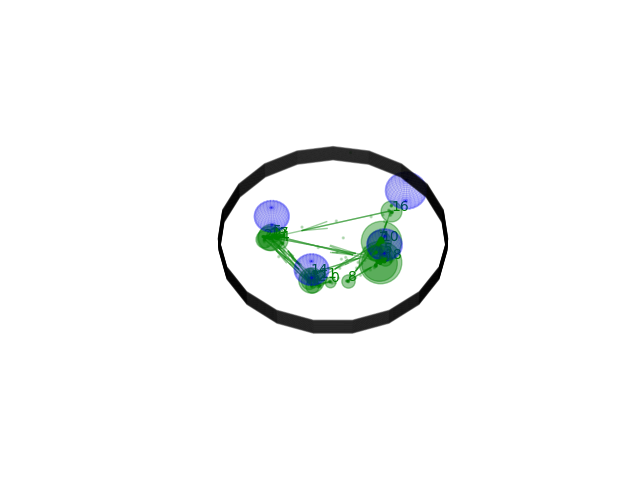

['Crown' 'Donut' 'FloorFocusArea' 'Table' 'Teapot' 'Tomato']
alloeye_10r1_16_enc


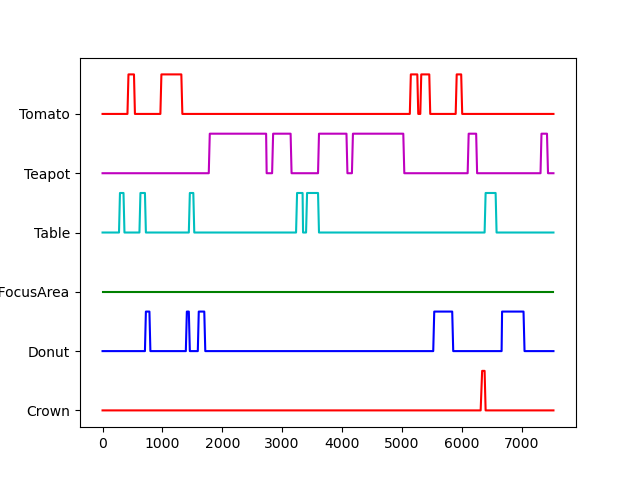

gc


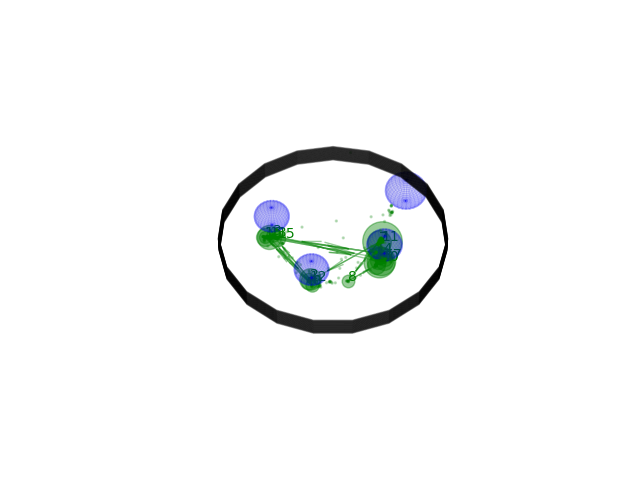

['Crown' 'Donut' 'FloorFocusArea' 'Table' 'Teapot' 'Tomato']
alloeye_10r1_16_enc


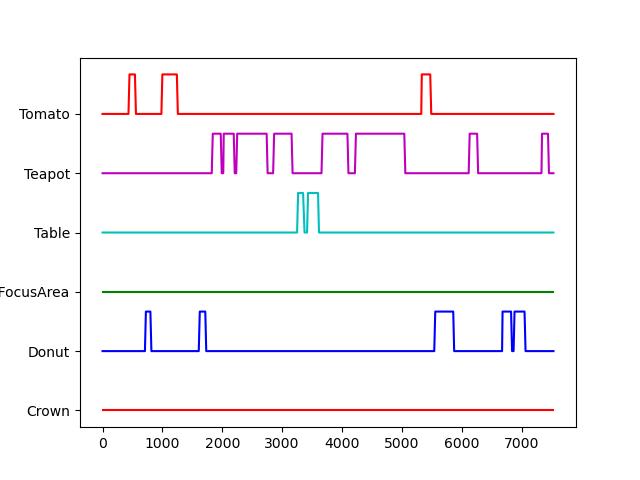

idt


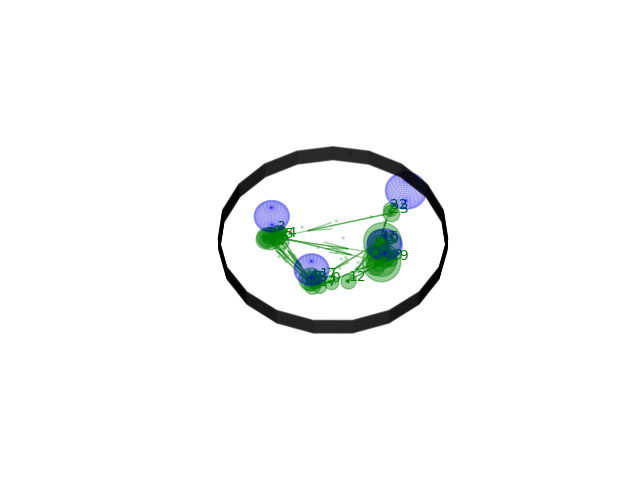

['Crown' 'Donut' 'FloorFocusArea' 'Table' 'Teapot' 'Tomato']
alloeye_10r1_16_enc


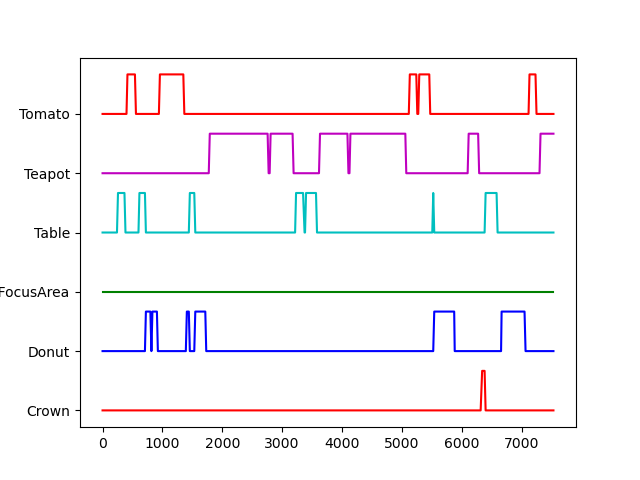

ihmm


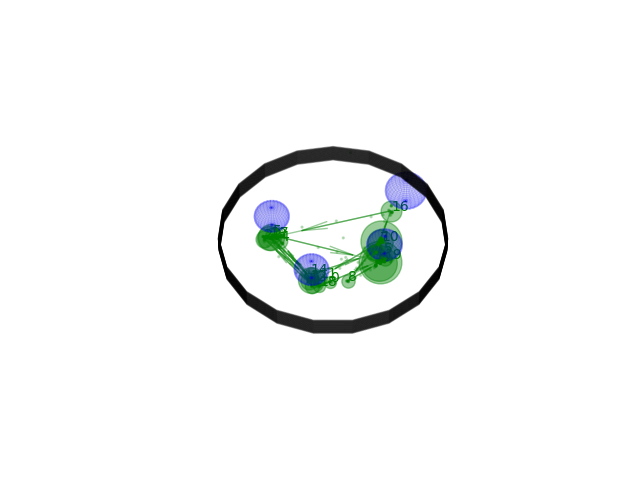

['Crown' 'Donut' 'FloorFocusArea' 'Table' 'Teapot' 'Tomato']
alloeye_10r1_16_enc


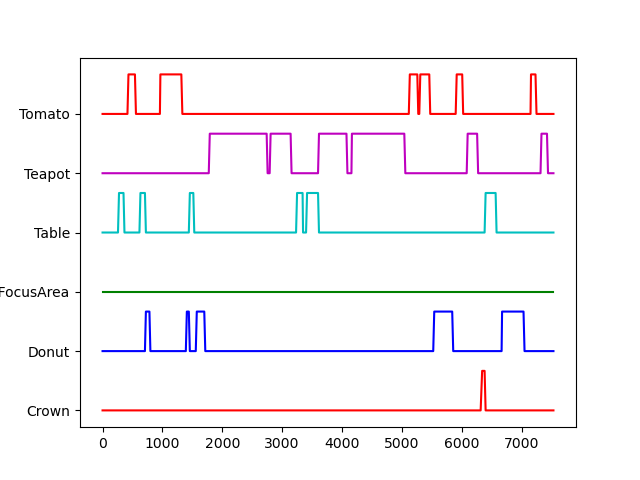

In [8]:
# compare all algorithms

# 3d plots
# ind=np.where(np.array(viewings) == 'alloeye_21r2_2_enc')[0][0]
ind = 0
print(ind)

for name, df in fix_dfs.items():
    print(name)
    tps = fix_tps[ind]
    fixation_plot(tps, fix_dfs[name][ind], gp_lab='missing')
    plt.show()
    
    # on off plots
    full_objects = np.unique(fix_tps[ind].gaze_object)
    print(full_objects)

    for obj in full_objects:
        tps[obj] = (tps.gaze_object == obj) & (tps[f'{name}_fixation'] == 1)
    on_off_plot(tps, full_objects)
    plt.show()




In [11]:
pair_names = []

from itertools import combinations, product

all_pairs = [comb for comb in combinations(list(algos.keys()), 2)]
pair_names = ["_".join(map(str, comb)) for comb in combinations(list(algos.keys()), 2)]
print(pair_names)
print(all_pairs)

['ivdt_gc', 'ivdt_idt', 'ivdt_ihmm', 'gc_idt', 'gc_ihmm', 'idt_ihmm']
[('ivdt', 'gc'), ('ivdt', 'idt'), ('ivdt', 'ihmm'), ('gc', 'idt'), ('gc', 'ihmm'), ('idt', 'ihmm')]


alloeye_40r1_4_enc
Cohen's kappa between ivdt and gc for alloeye_40r1_4_enc): 0.622
alloeye_40r1_4_enc
Cohen's kappa between ivdt and idt for alloeye_40r1_4_enc): 0.467
alloeye_40r1_4_enc
Cohen's kappa between ivdt and ihmm for alloeye_40r1_4_enc): 0.610
alloeye_40r1_4_enc
Cohen's kappa between gc and idt for alloeye_40r1_4_enc): 0.547


C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)
C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be

alloeye_40r1_4_enc
Cohen's kappa between gc and ihmm for alloeye_40r1_4_enc): 0.502
alloeye_40r1_4_enc
Cohen's kappa between idt and ihmm for alloeye_40r1_4_enc): 0.368


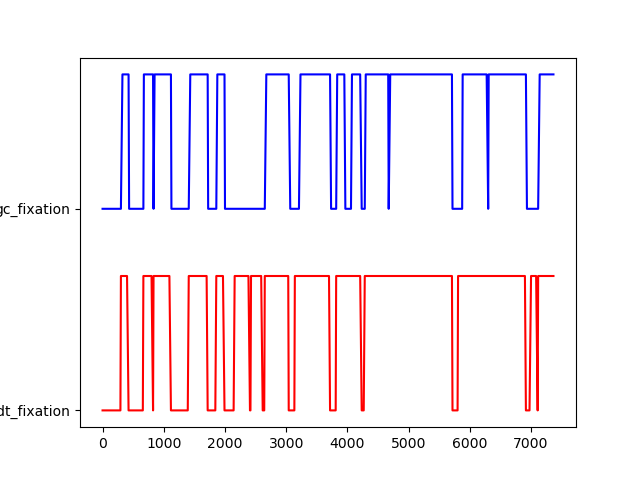

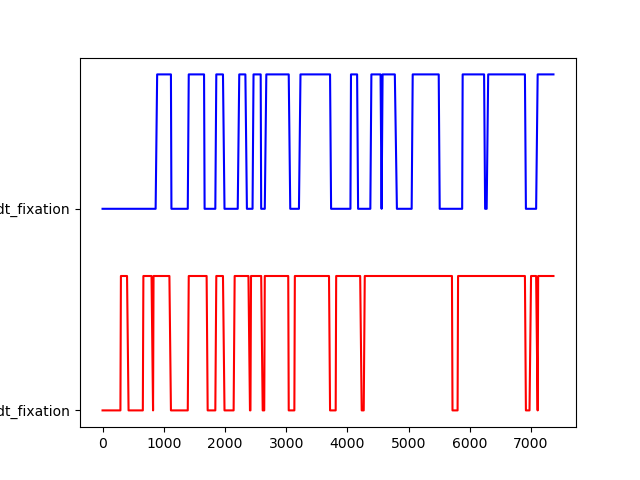

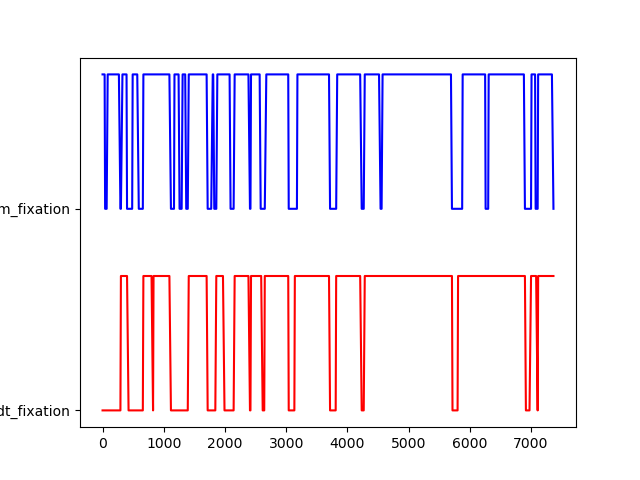

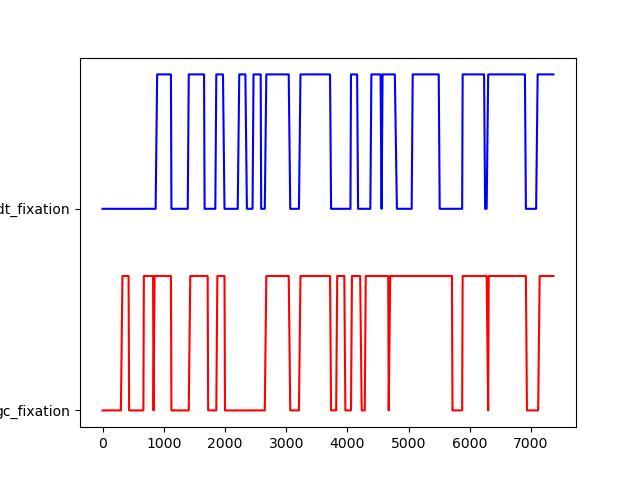

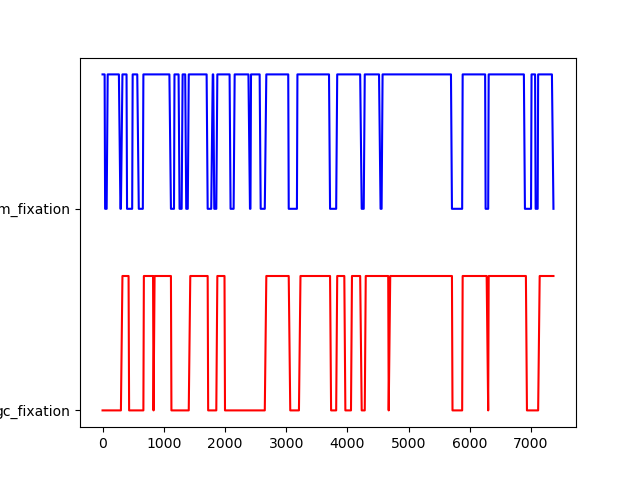

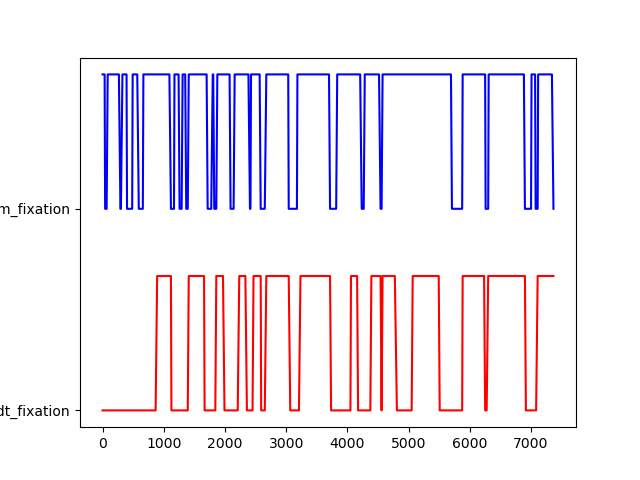

In [12]:
# fleiss's kappa
ind=0
from statsmodels.stats.inter_rater import cohens_kappa, aggregate_raters
from sklearn.metrics import cohen_kappa_score


for pair in all_pairs:
    tps = fix_tps[ind]
    fix_col_1 = f'{pair[0]}_fixation'
    fix_col_2 = f'{pair[1]}_fixation'
    
    # print(fix_col_1)
    # print(fix_col_2)
    tps = tps[np.invert(pd.isna(tps[fix_col_1]))]
    tps = tps[np.invert(pd.isna(tps[fix_col_2]))]
    
    algorithm_1_fixations = np.array(tps[fix_col_1].to_list(), dtype=int) # list of 1s and 0s indicating fixations
    algorithm_2_fixations = np.array(tps[fix_col_2].to_list(), dtype=int) # list of 1s and 0s indicating fixations
    
    if fix_col_1 not in add_tps:
        
    # create a list of annotations for each time point, where each annotation
    # is a tuple containing the two algorithm's fixation classifications
    # annotations = list(zip(algorithm_1_fixations, algorithm_2_fixations))
    # annotations, _ = aggregate_raters(np.array(np.vstack((algorithm_1_fixations, algorithm_2_fixations)), dtype=int).T)
    # print(annotations)

    # compute Cohen's kappa
    kappa = cohen_kappa_score(algorithm_1_fixations, algorithm_2_fixations)

    print(f"Cohen's kappa between {pair[0]} and {pair[1]} for {viewings[ind]}): {kappa:.3f}")

plot_cols = []
for key in algos.keys()
    plot_cols.append(f"{key}_fixation")
    
on_off_plot(tps, plot_cols)

C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


Text(0.5, 1.0, "Cohen's kappa by algorithm pair")

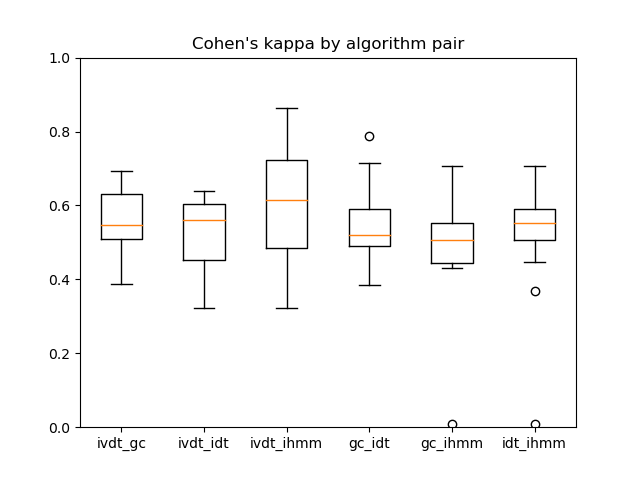

In [13]:
kappas = {}
for j in range(len(pair_names)):
    kappas.update({pair_names[j]: []})
    name_1 = all_pairs[j][0]
    name_2 = all_pairs[j][1]
    for i in range(len(viewings)):
        ind = i
        # assuming that you have two algorithms named algorithm_1 and algorithm_2
        # and each algorithm has added a column named 'fixation' to the time series
        # you can load the data into two lists:
        tps = fix_tps[ind]
        if tps is None:
            # kappas[pair_names[j]].append(np.nan)
            continue
        fix_col_1 = f'{name_1}_fixation'
        fix_col_2 = f'{name_2}_fixation'
        # print(fix_col_1)
        # print(fix_col_2)
        tps = tps[np.invert(pd.isna(tps[fix_col_1]))]
        tps = tps[np.invert(pd.isna(tps[fix_col_2]))]

        algorithm_1_fixations = np.array(tps[fix_col_1].to_list(), dtype=int) # list of 1s and 0s indicating fixations
        algorithm_2_fixations = np.array(tps[fix_col_2].to_list(), dtype=int) # list of 1s and 0s indicating fixations
        # print(algorithm_1_fixations.shape)
        # print(algorithm_2_fixations.shape)
        
        # compute kappa
        kappas[pair_names[j]].append(cohen_kappa_score(algorithm_1_fixations, algorithm_2_fixations))

ax = plt.figure().add_subplot()
labels, data = kappas.keys(), kappas.values()
ax.boxplot(data)
ax.set_xticks(range(1, len(labels) + 1), labels)
ax.set_ybound(0, 1)
ax.set_title(f"Cohen's kappa by algorithm pair")
    

In [14]:
# get viewings data


cols = ['n_fix_total', 'dwell_total', 'hn']
    
full_fix_dfs = {}
for name, dfs in fix_dfs.items():
    full_fix_dfs.update({name: fix_dfs[name][0]})

full_tp_df = fix_tps[0]
for i in range(1, len(viewings)):
    for name, dfs in fix_dfs.items():
        if dfs[i] is not None:
            full_fix_dfs[name] = pd.concat([full_fix_dfs[name], dfs[i]]).reset_index(drop=True)
        
    if fix_tps[i] is not None:
        full_tp_df = pd.concat([full_tp_df, fix_tps[i]]).reset_index(drop=True) 
    

view_df = fetch_viewings("all", viewing_list=viewings)
full_view_df = None
for name, dfs in fix_dfs.items():
    temp_df = to_viewing(view_df.copy(deep=True), full_fix_dfs[name], full_tp_df, fix_method=FixAlgo[algo_names[name]], features=cols)
    temp_df['algorithm'] = np.repeat(name, len(temp_df))
    full_view_df = temp_df if full_view_df is None else pd.concat([full_view_df, temp_df]).reset_index(drop=True)


for col in cols:
    full_view_df = full_view_df[np.invert(pd.isna(full_view_df[col]))].reset_index(drop=True)



- fetching viewings from db...
viewings fetched from db
Features added to df for 20 of 20 trials
Features added to df for 20 of 20 trials
Features added to df for 20 of 20 trials
not enough fixations or saccades for viewing alloeye_14r2_12_ret, skipping
Features added to df for 20 of 20 trials


In [28]:
display(full_view_df[full_view_df.n_fix_total > 100].style)

,viewing_id,ppt_id,study_id,block_id,trial_id,viewing_type,co_x_raw,co_z_raw,co_x_rot_adj,co_z_rot_adj,obj1_name,obj1_x,obj1_z,obj2_name,obj2_x,obj2_z,obj3_name,obj3_x,obj3_z,obj4_name,obj4_x,obj4_z,obj5_name,obj5_x,obj5_z,test_1,hn,hd,n_sacc_total,n_sacc_obj1,n_sacc_obj2,n_sacc_obj3,n_sacc_obj4,n_sacc_table,velocity_mean_total,velocity_std_total,n_fix_total,n_fix_obj1,n_fix_obj2,n_fix_obj3,n_fix_obj4,n_fix_table,n_fix_other,dwell_total,dwell_obj1,dwell_obj2,dwell_obj3,dwell_obj4,dwell_table,dwell_other,t_first_array,t_first_obj1,t_first_obj2,t_first_obj3,t_first_obj4,pupil_diam_centre,pupil_diam_spread,p_matrix,p_matrix_objects,n_fix_pp,dwell_pp,dispersion_mean,drop_out_total,n_blinks,dur_blinks,p_trackloss,algorithm
500,alloeye_35r2_12_ret,alloeye_35,alloeye,alloeye_35r2,alloeye_35r2_12,ret,0.041703,-0.034421,0.041703,-0.034421,Apple,0.041703,-0.034421,Crown,-0.555978,-0.289939,Box,-0.308462,-0.000999,Pipe,-0.303382,-0.566972,None,nan,nan,None,0.691950,0.629802,18.000000,5.000000,4.000000,2.000000,3.000000,3.000000,0.010872,0.019866,999.000000,8.000000,20.000000,10.000000,6.000000,6.000000,2.000000,999.000000,2248.000000,3248.000000,2582.000000,1150.000000,1766.000000,250.000000,441.000000,1583.000000,441.000000,1366.000000,866.000000,4.284081,0.212565,"[[0.0, 0.15384615384615385, 0.07692307692307693, 0.0, 0.0, 0.0], [0.23076923076923078, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.07692307692307693, 0.0, 0.15384615384615385, 0.07692307692307693, 0.0], [0.0, 0.0, 0.15384615384615385, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0]]","[""Apple"", ""Box"", ""Crown"", ""Pipe"", ""Table"", ""Well""]",0.000000,0.000000,0.018907,0.000000,3.000000,1728.000000,0.237950,idt


In [15]:
full_view_df = full_view_df[full_view_df.n_fix_total != 999]

In [16]:
# display(view_df.head(2).style)
print(full_view_df.shape)
display(full_view_df[full_view_df.dwell_total <= 10].style)
# pyg.walk(view_df, hideDataSourceConfig=True, dark='dark')

(80, 67)


,viewing_id,ppt_id,study_id,block_id,trial_id,viewing_type,co_x_raw,co_z_raw,co_x_rot_adj,co_z_rot_adj,obj1_name,obj1_x,obj1_z,obj2_name,obj2_x,obj2_z,obj3_name,obj3_x,obj3_z,obj4_name,obj4_x,obj4_z,obj5_name,obj5_x,obj5_z,test_1,hn,hd,n_sacc_total,n_sacc_obj1,n_sacc_obj2,n_sacc_obj3,n_sacc_obj4,n_sacc_table,velocity_mean_total,velocity_std_total,n_fix_total,n_fix_obj1,n_fix_obj2,n_fix_obj3,n_fix_obj4,n_fix_table,n_fix_other,dwell_total,dwell_obj1,dwell_obj2,dwell_obj3,dwell_obj4,dwell_table,dwell_other,t_first_array,t_first_obj1,t_first_obj2,t_first_obj3,t_first_obj4,pupil_diam_centre,pupil_diam_spread,p_matrix,p_matrix_objects,n_fix_pp,dwell_pp,dispersion_mean,drop_out_total,n_blinks,dur_blinks,p_trackloss,algorithm


In [17]:
def subboxplots(df, cols, x_grouping, xlabs, n_cols = 4):
    n_cols = n_cols
    n_rows = int(np.ceil(len(cols)/n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5), dpi=100)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.6,
                        top=0.9,
                        wspace=0.6,
                        hspace=0.6)
    # ticks = list(replace_map.values())
    # labels = list(replace_map.keys())
    for i in range(len(cols)):
        row = int(np.floor(i/n_cols))
        col = i % n_cols
        feat = cols[i]
        if n_rows > 1:
            plt.sca(axes[row, col])
            df.groupby(by=x_grouping).boxplot(column=feat, subplots=False)
            # axes[row, col].set_xticks(ticks)
            axes[row, col].set_xticklabels(xlabs)
            axes[row, col].set_title(feat)
            axes[row, col].grid(None)
        else:
            plt.sca(axes[col])
            df.groupby(by=x_grouping).boxplot(column=feat, subplots=False)
            # axes[row, col].set_xticks(ticks)
            axes[col].set_xticklabels(xlabs)
            axes[col].set_title(feat)
            axes[col].grid(None)

C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


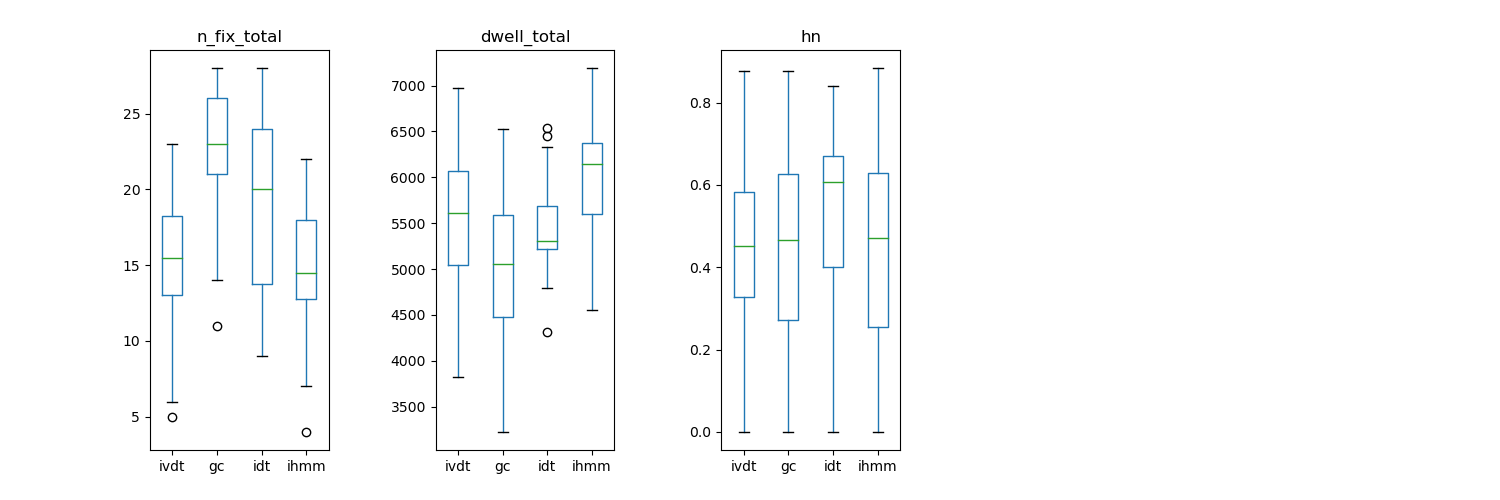

In [18]:
cols = ['n_fix_total', 'dwell_total', 'hn']
subboxplots(full_view_df, cols, 'algorithm', list(fix_dfs.keys()), n_cols=3)

In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm


# Specify the formula for the mixed model
# "number_of_fixations ~ algorithm + viewing + (1|participant) + (1|trial)"
formula = "n_fix_total ~ algorithm"
vc = {'trial_id': '0 + C(trial_id)', 'viewing_id': '0 + C(viewing_id)'}

full_view_df.algorithm = full_view_df.algorithm.astype('category')
full_view_df.ppt_id = full_view_df.ppt_id.astype('category')
full_view_df.trial_id = full_view_df.trial_id.astype('category')
# print(view_df.dtypes)

# Fit the mixed model using the formula and your data
model = mixedlm(formula, vc_formula=vc, data=full_view_df, groups="ppt_id", re_formula="1",)


# Print the results
print(model.fit().summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  n_fix_total
No. Observations:  80       Method:              REML       
No. Groups:        8        Scale:               6.4270     
Min. group size:   8        Log-Likelihood:      -206.1308  
Max. group size:   16       Converged:           Yes        
Mean group size:   10.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         15.596    1.334 11.688 0.000 12.981 18.211
algorithm[T.idt]   7.100    0.802  8.856 0.000  5.529  8.671
algorithm[T.ihmm]  3.700    0.802  4.615 0.000  2.129  5.271
algorithm[T.ivdt] -0.450    0.802 -0.561 0.575 -2.021  1.121
ppt_id Var         8.016    1.826                           
trial_id Var       0.140                                    
viewing_id Var     8.999    1.735   

C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Luke\anaconda3\envs\alloeyepy\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [19]:
# ind=0
# viewing_id = viewings[ind]
# fix_df = pd.concat([full_gc_df[full_gc_df.viewing_id == viewing_id], full_idt_df[full_idt_df.viewing_id == viewing_id]])
# print(viewing_id[:-4])
# trial_row = fetch_trials('all', trial_ids=[viewing_id[:-4]])
# # print(trial_row)

In [20]:
# ea_td(trial_row, fix_df, comparison='algorithm', algorithms=('GazeCollision', 'VR_IDT'))

In [20]:
viewings_clean = np.unique(full_view_df.viewing_id)
distances = {}
for j in range(len(pair_names)):
    distances.update({pair_names[j]: []})
    name_1 = all_pairs[j][0]
    name_2 = all_pairs[j][1]
    for i in range(len(viewings_clean)):
        viewing_id = viewings_clean[i]
        df_1 = full_fix_dfs[name_1]
        df_2 = full_fix_dfs[name_2]
        if df_1 is None or df_2 is None:
            continue
        fix_df = pd.concat([df_1[df_1.viewing_id == viewing_id], df_2[df_2.viewing_id == viewing_id]])

        trial_row = fetch_trials('all', trial_ids=[viewing_id[:-4]])
        distance = ea_td(trial_row, fix_df, comparison='algorithm', algorithms=(algo_names[name_1], algo_names[name_2]))
        if i == 0:
            print(distance)
        distances[pair_names[j]].append(distance)

1.285615034796587


C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:227: RuntimeWarning: invalid value encountered in double_scalars
  view1_fix_norm.centroid_x = (view1_fix_norm.centroid_x.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:227: RuntimeWarning: invalid value encountered in true_divide
  view1_fix_norm.centroid_x = (view1_fix_norm.centroid_x.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:228: RuntimeWarning: divide by zero encountered in double_scalars
  view1_fix_norm.centroid_z = (view1_fix_norm.centroid_z.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:228: RuntimeWarning: divide by zero encou

1.270548199015712


C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:227: RuntimeWarning: invalid value encountered in double_scalars
  view1_fix_norm.centroid_x = (view1_fix_norm.centroid_x.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:227: RuntimeWarning: invalid value encountered in true_divide
  view1_fix_norm.centroid_x = (view1_fix_norm.centroid_x.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:228: RuntimeWarning: divide by zero encountered in double_scalars
  view1_fix_norm.centroid_z = (view1_fix_norm.centroid_z.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:228: RuntimeWarning: divide by zero encou

0.8536014273964571
0.6468973445616821


C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:227: RuntimeWarning: invalid value encountered in double_scalars
  view1_fix_norm.centroid_x = (view1_fix_norm.centroid_x.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:227: RuntimeWarning: invalid value encountered in true_divide
  view1_fix_norm.centroid_x = (view1_fix_norm.centroid_x.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:228: RuntimeWarning: divide by zero encountered in double_scalars
  view1_fix_norm.centroid_z = (view1_fix_norm.centroid_z.to_numpy() - grand_mean) / grand_std
C:\Users\Luke\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\feature_calculate\viewing_compare_calcs.py:228: RuntimeWarning: divide by zero encou

1.0541577809265525
0.9856860702237017


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

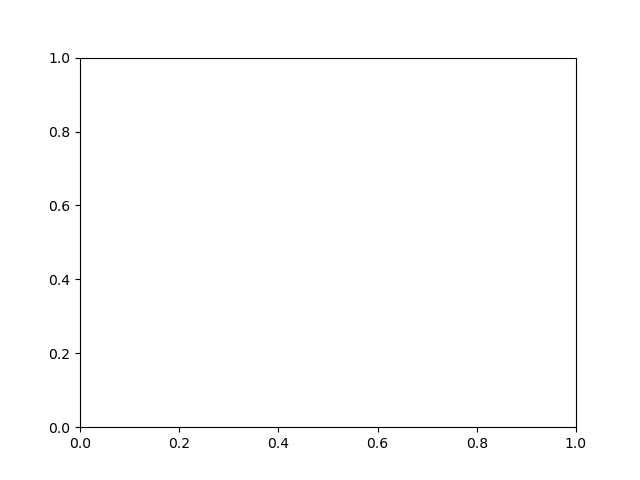

In [28]:
ax = plt.figure().add_subplot()
labels, data = distances.keys(), distances.values()
print(np.isnan(data))
data = data[~pd.isna(data)]
ax.boxplot(data)
ax.set_xticks(range(1, len(labels) + 1), labels)
ax.set_title(f"Eyeanalysis distances by algorithm pair")

In [23]:
# plt.figure().add_subplot().hist(distances)

In [24]:
view_df.viewing_id[view_df.n_fix_total > 500]
# np.where(view_df.viewing_id == 'alloeye_21r2_2_enc')

Series([], Name: viewing_id, dtype: object)

In [22]:
distances

{'ivdt_gc': [1.285615034796587,
  0.7157132742633543,
  0.8154824722637565,
  0.08881468932529829,
  0.4980688366411631,
  1.5526031865522614,
  1.1890128565581155,
  1.6373665660704915,
  1.571707665573387,
  1.3553624358789897,
  0.2322839849735198,
  0.8744186108483533,
  0.5539059544533276,
  0.7703375776227168,
  0.9280450449286121,
  1.2216253852150414,
  nan,
  1.5374658831025503,
  1.0238838492928448,
  0.7158702609132385],
 'ivdt_idt': [1.270548199015712,
  0.8241933260770065,
  0.9283859375633674,
  0.49367287870418686,
  0.6631178003203215,
  1.1017349830934187,
  1.0764951162854808,
  1.787196519879143,
  0.982362485763992,
  1.8758233333429164,
  0.48487190329686086,
  1.0161824400442196,
  0.732202695411455,
  1.1323272056795608,
  1.085322551066382,
  0.8230106231442049,
  nan,
  1.4838573100889296,
  0.7256202531580308,
  1.1421560204141037],
 'ivdt_ihmm': [0.8536014273964571,
  nan,
  0.9157468890243873,
  0.3624847799809012,
  0.10922203512496358,
  0.9336729661333069

In [26]:
# plot saccades - check for noise - might need to exclude these features